In [1]:
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as transforms
import torchvision
from torchvision.models.inception import inception_v3

from PIL import Image

import matplotlib.pyplot as plt
import os
import numpy as np

# Util function for image dispaly

In [12]:
def displayMNIST (img):
    ''' Display MNIST image where pixels are without value 0-1
    '''

    if not (type(img) is np.ndarray) : 
        raise TypeError("Only numpy.array is supported")
    if not (img.ndim == 3 and img.shape[0] == 1):
        raise AttributeError("Expects (1, 28, 28) shape")
    
    img = np.squeeze(img, axis=0) * 255
    pixels = img.reshape((28, 28))
    
    # Create 2-inch by 2-inch image
    plt.figure(figsize=(1.5,1.5))
    plt.imshow(pixels, cmap='gray')
    plt.show()

def display_images(images, titles):
    ''' Display multiple images horizontally '''
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    for ax, image, title in zip(axes, images, titles):
        ax.imshow(image.squeeze(), cmap='gray')
        ax.set_title(title)
        ax.axis('off')
    plt.show()
    

# Define an example of attack: Iterative FGSM

In [18]:
def zero_gradients(i):
    if i.grad is not None:
        i.grad.data.zero_()


def iterative_FGSM_attack (img, label, model):    
    eps = 4 * 8 / 225.     
    # eps = 1 * 8 / 225. 
    steps = 100
    norm = float('inf')
    # step_alpha = 0.05 
    step_alpha = 0.01 
    loss = nn.CrossEntropyLoss()
    
    x, y = Variable(img, requires_grad=True), Variable(label)
    result = img
    adv = torch.zeros(result.shape)
    for step in range(steps):
        zero_gradients(x)
        out = model(x)        
        # Returns the maximum value of each row of the input tensor in the given dimension dim
        _ , y.data = torch.max(out.data, 1)
        
        if ((not (y.data == label)) and step > 1) :
            return result.cpu(), adv.cpu(), True
            print("perturbed input for "+ str(label[0])+  " is now identified to be: "+ str(y.data[0]))
            
        _loss = loss(out, y)
        _loss.backward()
        normed_grad = step_alpha * torch.sign(x.grad.data)
        step_adv = x.data + normed_grad
        adv = step_adv - img
        adv = torch.clamp(adv, -eps, eps)
        result = img + adv
        # torch.clamp(input, min, max, out=None) → Tensor
        # Clamp all elements in input into the range [min, max] and return a resulting Tensor.
        result = torch.clamp(result, 0.0, 1.0)
        x.data = result        
        
    return result.cpu(), adv.cpu(), False

In [36]:
4 * 8 / 225

0.14222222222222222

# Let's first build our Model  -- MNIST example 

### 0- Define some hyperparameters needed before starting the training 

In [4]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Hyper-parameters 
num_classes = 10
num_epochs = 5
batch_size = 64
learning_rate = 0.001
sizeOfNeuronsToMonitor = 40

### 1- We first need the load the data

In [5]:
# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='data/mnist', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='data/mnist', 
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

Let test if we load our data correctely

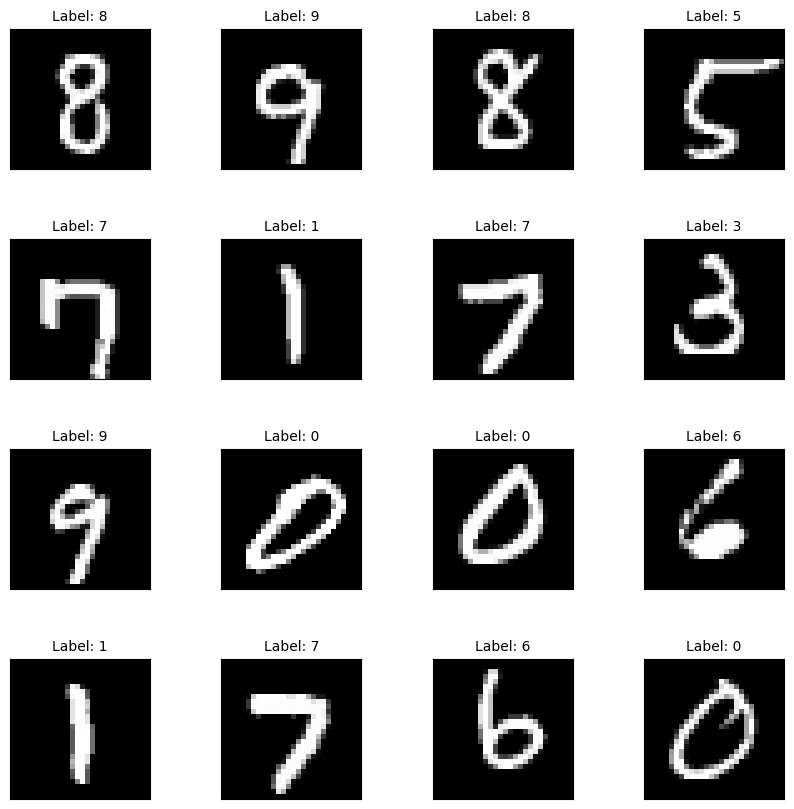

In [6]:
def displayMNISTGrid(images, labels, nrows=4, ncols=4):
    ''' Display a grid of MNIST images with labels on top '''
    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 10))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)
    
    for i in range(nrows):
        for j in range(ncols):
            idx = i * ncols + j
            ax = axes[i, j]
            ax.imshow(images[idx].squeeze(), cmap='gray')
            ax.set_title(f"Label: {labels[idx].item()}", fontsize=10)
            ax.set_xticks([])
            ax.set_yticks([])
    
    plt.show()

# Example usage:
for images, labels in train_loader:
    displayMNISTGrid(images[:16], labels[:16])
    break

### 2- Define the Model

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class NeuralNet(nn.Module):
    
    def __init__(self):
        super(NeuralNet, self).__init__()
 
        self.conv1 = nn.Conv2d(1, 40, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(40, 20, 5)
        self.fc1 = nn.Linear(20 * 4 * 4, 160)
        self.fc2 = nn.Linear(160, 80)
        self.fc3 = nn.Linear(80, sizeOfNeuronsToMonitor)
        self.fc4 = nn.Linear(sizeOfNeuronsToMonitor, num_classes)
        
    def forward(self, x):
        # Original 28x28x1 -(conv)-> 24x24x40 -(pool)-> 12x12x40
        x = self.pool(F.relu(self.conv1(x)))
        # Original 12x12x40 -(conv)-> 8x8x20 -(pool)-> 4x4x20
        x = self.pool(F.relu(self.conv2(x)))
        # Flatten it to an array of inputs
        x = x.view(-1, 20 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        out = self.fc4(x)
        return out 
  
    # Here we add another function, which does the same forward computation but also extracts intermediate layer results
    def forwardWithIntermediate(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 20 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        intermediateValues = x
        x = F.relu(x)
        out = self.fc4(x)
        return out, intermediateValues    
    
net = NeuralNet()
net.eval()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)  

Load the model (if you have a pretrained one)

In [8]:
# Load the trained model
checkpoint = torch.load('trained_model.pth')
net.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

# Set the model to evaluation mode
net.eval()

NeuralNet(
  (conv1): Conv2d(1, 40, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(40, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=320, out_features=160, bias=True)
  (fc2): Linear(in_features=160, out_features=80, bias=True)
  (fc3): Linear(in_features=80, out_features=40, bias=True)
  (fc4): Linear(in_features=40, out_features=10, bias=True)
)

Train the Model using the Train Data

In [9]:
furtherTrain = False

if furtherTrain: 

    # Train the model
    total_step = len(train_loader)
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):  
            # Move tensors to the configured device
            labels = labels.to(device)

            # Forward pass
            outputs = net(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

In [10]:
#save the model
SaveModel = False
if SaveModel:
    torch.save({
        'epoch': num_epochs,
        'model_state_dict': net.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, 'trained_model.pth')

Compute accuracy of the model using test data

In [9]:
# In test phase, we don't need to compute gradients (for memory efficiency)

with torch.no_grad():
    correct = 0
    outofActivationPattern = 0
    outofActivationPatternAndResultWrong = 0
    
    total = 0
    for images, labels in test_loader:
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

Accuracy of the network on the 10000 test images: 98.82 %


# Adverserial attack: Iterative FGSM attack 

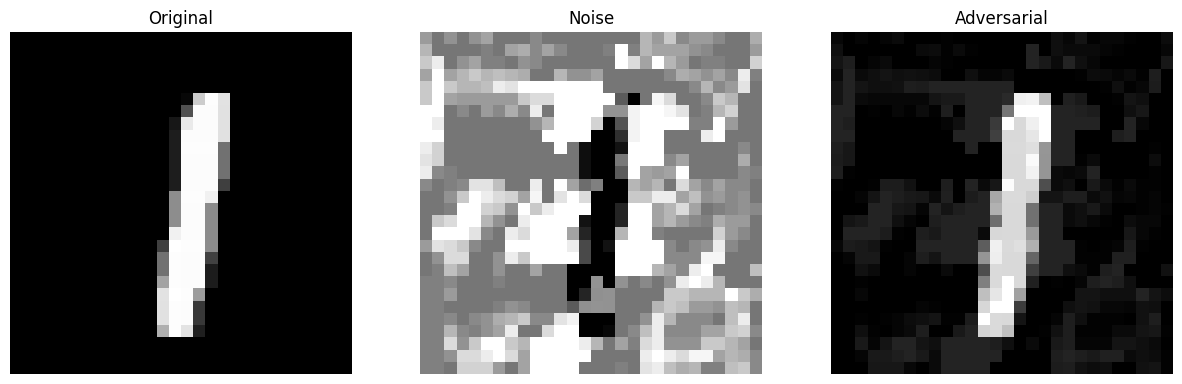

Predicted label for the original image: 1
Predicted label for the perturbed image: 7


In [19]:
# Original image and label
img = images[0].unsqueeze(0)
label = labels[0].unsqueeze(0)

# Perform iterative FGSM attack
adv_img, noise, attackSuccessful = iterative_FGSM_attack(img, label, net)


adv_img_np = adv_img.squeeze().detach().cpu().numpy()
original_img_np = img.squeeze().detach().cpu().numpy()


display_images([original_img_np, noise.squeeze().cpu().numpy(), adv_img_np], ['Original', 'Noise', 'Adversarial'])



# Let's check the decision of NN for the original image and perturbed image 
original_img_tensor = img.to(device)
perturbed_img_tensor = adv_img.to(device)

# Forward pass through the model
output_original_img = net(original_img_tensor)
output_perturbed_img = net(perturbed_img_tensor)

# Get the predicted class
_, predicted_original_img = torch.max(output_original_img.data, 1)
_, predicted_perturbed_img = torch.max(output_perturbed_img.data, 1)

# Convert the predicted class to a human-readable label
predicted_label_original_img = predicted_original_img.item()
predicted_label_perturbed_img = predicted_perturbed_img.item()

print("Predicted label for the original image:", predicted_label_original_img)
print("Predicted label for the perturbed image:", predicted_label_perturbed_img)

#### Use:  https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial10/Adversarial_Attacks.html